# Assignment 5: Randomization test 2
## Learning Outcomes
We will continue our last homework on the use of randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. The first two task build on the last homework and run randomization tests with two new test statistics. You should re-use the randomization test function that you wrote for the last homework – but the new modified version needs to be included in the submission. In Task 3 you are asked to program a simple monte-Carlo simulation test.  
## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib. Load the movie data set into a pandas data frame. **IMPORTANT: Download and used the new movie data set that comes with this assignment on OWL**. Because we are using plots make sure that you configure your notebook such that plots are shown inline (see Assignment 2). 

In [223]:
# importing packages
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.stats as stats

df = pd.read_csv('movieDataset.csv')
df

,Unnamed: 0,boxoff,prodcost,dirIncome,dirGender,year,month,genre,numTheatres
0,0,88.648583,44.742936,1.143234,male,2012,3,comedy,139
1,1,145.334924,38.835516,3.393535,female,2014,11,drama,213
2,2,238.265684,29.532283,2.418883,male,2015,6,other,100
3,3,212.714742,157.111899,2.034115,male,2014,10,adventure,436
4,4,120.175461,30.547155,0.963219,female,2012,1,comedy,115
...,...,...,...,...,...,...,...,...,...
245,245,187.231562,72.743712,3.105438,male,2012,12,adventure,366
246,246,215.713195,136.851707,1.917771,male,2013,7,adventure,285
247,247,166.827002,50.684470,2.414571,male,2014,1,other,233
248,248,223.226998,40.103513,2.176928,male,2015,2,drama,489


## TASK 1: Chi-square test of independence (40pts)
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts (see lecture).  
### Question 1: Null-hypothesis (5pts)
We want to test the hypothesis that there is a systematic relationship between director Gender and film genre. Please formulate the corresponding Null-hypothesis.

The Null-Hypothesis would be that there is no systematic relationship between director Gender and film genre.

### Question 2: Expected frequencies (10pts)
From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged. 

In [224]:
#observed frequencies table:
obs_ctab = pd.crosstab(df['genre'], df['dirGender'])
display(obs_ctab)
obs_array = np.array(obs_ctab)
#expected frequencies table:
[n_row, n_col] = obs_array.shape
exp_array = np.zeros([n_row, n_col])
#print(exp_array)

#print(obs_array)
for c in range(len(obs_ctab.index)):
    for r in range(len(obs_ctab.columns)):
        #print((obs_array[c,:]))
        comp_1 = np.sum(obs_array[c,:])
        #print((obs_array[:,r]))
        comp_2 = np.sum(obs_array[:,r])
        table_total = np.sum(obs_array.flatten()) #to make it 1D
        #print(obs_array.flatten())
        exp_array[c,r] = (comp_1*comp_2)/(table_total)
#print(exp_array)
exp_ctab = pd.DataFrame(exp_array)
exp_ctab.columns = obs_ctab.columns
#display(exp_ctab)
# set the index to be the same as observed_tab
exp_ctab.index = obs_ctab.index
#display(exp_ctab)

display(exp_ctab)

dirGender,female,male
genre,,
action,9,48
adventure,6,58
comedy,13,35
drama,5,31
other,4,41


dirGender,female,male
genre,,
action,8.436,48.564
adventure,9.472,54.528
comedy,7.104,40.896
drama,5.328,30.672
other,6.660,38.340


### Question 3: Chi-square (10pts)
Create one function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

Report the value of this statistic for the real data. 


In [225]:
def Chi_square(dataframe):
    obs_ctab = pd.crosstab(dataframe['genre'], df['dirGender'])
    #display(obs_ctab)
    obs_array = np.array(obs_ctab)
    
    difference = obs_array - exp_array
    #print(difference)
    sq_diff = difference**2
    #print(sq_diff)
    div_exp = sq_diff / exp_array
    #print(div_exp)

    X2 = np.sum(div_exp.flatten())
    return X2

In [226]:
chi = Chi_square(df)
print(chi)

8.552102881235571


### Question 4: Randomization with flexible input arguments (5pts)
Rewrite the randomization function from the last homework, so it it becomes more versatile by adding additional input arguments that determines the behavior of the routine. 

- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 


In [232]:
def perm_test(data, fcn, col='dirGender', n_iter=500, n_sides = 1, n_bins=20):
    
    """
    Args:
        data (pd.dataframe) - input dataset
        n_iter (int) - number of iterations
        genre (str) - movie genre to select
        var (str) - column to permute
        
    Returns:
        stat (np.ndarray) - array of test statistics
        p_val (float) - p-value of the test statistic
    """
    
    # initialize stat array
    stat = np.zeros([n_iter])
        
    ## 1. create a copy of the data
    d = data.copy()
    d = d[d['dirIncome']==col].reset_index(drop=1)
    #display(d)
    
    ## 2. create an array that represent the indices
    idx = np.arange(len(d.index))

    for i in range(n_iter):
        
        ## 3. randomly shuffle indices
        np.random.shuffle(idx)
        
        ## 4. shuffle the selected variable
        shuff_var = d['dirIncome'].iloc[idx]
        
        ## 5. reorder the shuffled indices
        shuff_var = shuff_var.reset_index(drop=1)
        
        ## 6. put the shuffled gender variable back in
        d['dirIncome'] = shuff_var
        #display(d)
        
        ## 7. calculate test statistic
        stat[i] = avg_income_diff(d, col='dirGender')
    
    ## 8. plot the histogram of results
    sns.distplot(stat) 
    plt.xlabel('Distribution of differences in avg income')
    
    # 9. calculate and mark the value of the empirical test statistics
    diff = fcn
    print(f'The empirical difference in avg incomes is: {diff:.6f}')
    plt.axvline(diff, color = 'red', alpha = 1, lw = 1.5)
    
    ## 10. calculate the p-value
    H1 = stat > diff
    N = sum(H1)
    p_val = N/len(stat)        
    
    return stat, p_val

stat, p_val = perm_test(df,Chi_square, n_iter=1000)
print(f'The p-value of the test statistic is: {p_val:.6f}')

TypeError: float() argument must be a string or a number, not 'function'

### Question 5: Randomization test (5pts)
Perform a randomization test for the Chi-square test of independence. Your function should plot the histogram and report the p-value.

### Question 6: Conclusion (5pts)
Written response: Based on the results, what can you conclude from this test? 

# TASK 2: Randomization test for mean differences (25pts)
In this task we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

### Question 1: Null hypothesis (5pts)
Formulate the Null-hypothesis. 

Female and Male directors have the same annual income

### Question 2: Difference of means (8pts)
Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value. 

In [203]:
def diff_sal(gender1, gender2):
    g_income = df['dirIncome'].groupby(df['dirGender'])
    sub_groups_gender1 = g_income.get_group(gender1)
    sub_groups_gender1_mean = sub_groups_gender1.mean()
    sub_groups_gender2 = g_income.get_group(gender2)
    sub_groups_gender2_mean = sub_groups_gender2.mean()
    
    diff = sub_groups_gender1_mean - sub_groups_gender2_mean
    return diff

In [105]:
#test = diff_sal('male', 'female')
#print(test)

### Question 3:  Randomization test (7pts)
Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test. 

### Question 4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?  


# Task 3: Monte-Carlo simulation test (35pt)
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).
### Question 1: Monte Carlo simulation (15pts)
Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials (see lecture handout for tips).

In [116]:
def monteCarloSim(prob_succ, N, numIter):
    """
    inputs:
    prob_succ: probability of a success (heads) on each coin toss
    N: number of coin tosses
    numIter: number of times experiment is repeated
    
    returns:
    np.array(range(numIter)) that holds the recorded number of heads 
    """
    
    array = np.zeros([numIter])

    for i in range(numIter):
        samples = np.random.choice(a = [0,1], size = N, replace = True, p = [1 - prob_succ, prob_succ])
        #print(samples)
        num_heads = np.sum(samples)
        #print(num_heads)
        array[i] = num_heads
    return array

In [117]:
test = monteCarloSim(0.5, 20, 12)
print(test)

[15.  8. 12.  8.  6. 11. 10.  6.  9. 12. 14. 11.]


### Question 2: Monte Carlo Test (15pts)
Write a function (monteCarloTest) that uses monteCarloSim to simulate 1000 trials. The function should also plot a histogram of the recorded number of heads, and mark the real measured number with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads. Input arguments should be a) the probability of a success under the Null-hypothesis, b) the number of coin tosses per trial, and c) the measured number of heads. Use the function to evaluate the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%. 

In [ ]:
def monteCarloTest(p_success, N, numIter = 1000): #function that does the test, calls the simulation that does monte carlo
    head_array = monteCarloSim(p_success, N, numIter) #this function has 3 inputs. N is number of coin tosses. 
    #plot the histogram for head_array
    
    #put a vertical line on the histogram (represents the observed number of heads)
    
    #calculate the probability 
        #p_value = 
    
    return p_value

#think of complications as successes
#N = 62
#prob of complication = 10%

In [201]:
def monteCarloTest(prob_succ, N, numIter = 1000):
    
    """
    Null-hypothesis: (Prob of complication given experiment number of heads) >= (probability of complication) = 0.1
    Alternative hypothesis: (Prob of complication given experiment number of heads) < (probability of complication) = 0.1
    
    inputs:
    prob_succ: probability of a success (heads) on each coin toss under null hypothesis
    N: number of coin tosses per trial
    numIter: measured/observed number of heads
    
    
    evaluates the probability to get 3 complications in 62 cases - prob of complication is 10%. 
   
    Count in how many cases a value equal or smaller than the measured value is produced
    
    
    returns: 
    the probability that the experiment number of heads is <= observed number of heads
    """
    
    head_array = monteCarloSim(prob_succ, N, numIter) #this function has 3 inputs. N is number of coin tosses. 
    
    #hist for head_array:
    sns.histplot(head_array) 
    plt.xlabel('Distribution of recorded number of heads')
    plt.ylabel('Number of observations')
    
    #plot real measured number on axvline 
    real = head_array.mean()
    plt.axvline(real, color = 'red', alpha = 1, lw = 1.5)
    
    #calculate probability
    H1 = head_array > real
    N = sum(H1)
    p_val = N/len(head_array)
    return p_val

0.532


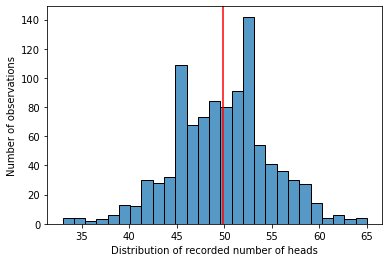

In [202]:
test = monteCarloTest(0.5, 100)
print(test)

0.644


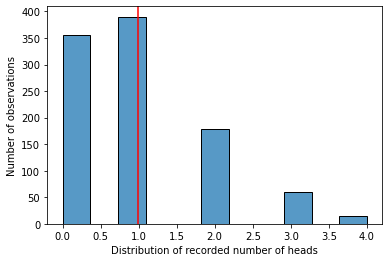

In [195]:
comp = monteCarloTest(0.0483, 20)
print(comp)

### Question 3: Conclusion (5pts)
Written answer: What do you conclude about the claim that the work of advisor R is lowering complication rates?